# Knowledge Based Recommendation System of Ingredients
## Notebook 1: Exploratory Data Analysis and Preprocessing
### Project Breakdown
    1  Exploratory Data Analysis and Preprocessing
    2: Build Word Embeddings using Word2Vec, FastText
    3: Recommend Recipes based on ingredients
    4: Build and Visualize Interactive Knowledge Graph of Ingredients



[This is the dataset](https://eightportions.com/datasets/Recipes/#fn:1) we will be using. It is collated by Ryan Lee, sourced from [Food Network](https://www.foodnetwork.com/), [Epicurious](https://www.epicurious.com/), and [Allrecipes](https://www.allrecipes.com/).

## Data Preparation

In [1]:
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from gensim.parsing.preprocessing import remove_stopwords
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import pickle
import string
import nltk
import json
import re

In [2]:
# download recipe data
!mkdir -p data
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://eightportions.com/" "https://storage.googleapis.com/recipe-box/recipes_raw.zip" -c -O 'data/recipes_raw.zip'

--2022-01-12 15:58:46--  https://storage.googleapis.com/recipe-box/recipes_raw.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 74.125.137.128, 2607:f8b0:4023:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53355492 (51M) [application/zip]
Saving to: ‘data/recipes_raw.zip’

data/recipes_raw.zi 100%[===================>]  50.88M  58.4MB/s    in 0.9s    

2022-01-12 15:58:47 (58.4 MB/s) - ‘data/recipes_raw.zip’ saved [53355492/53355492]



In [3]:
!unzip -xo data/recipes_raw.zip -d data

Archive:  data/recipes_raw.zip
  inflating: data/recipes_raw_nosource_ar.json  
  inflating: data/recipes_raw_nosource_epi.json  
  inflating: data/recipes_raw_nosource_fn.json  
  inflating: data/LICENSE            


In [4]:
# we scrapped data from three sources
recipe_sources = ['ar', 'epi', 'fn']

In [5]:
# We will iterate all json files to build a dataframe
recipes = pd.DataFrame()

sources, titles, ingredients, instructions = [], [], [], []

for recipe_source in recipe_sources:
    with open(f'data/recipes_raw_nosource_{recipe_source}.json', 'r') as fn:
        data = json.load(fn)
        for _, recipe in data.items():
            if ('title' in recipe) and ('ingredients' in recipe) and ('instructions' in recipe):
                # append to a list of the source
                sources.append(recipe_source)

                # append to a list of the titles
                titles.append(recipe['title'])

                # append to a list of a list of ingredients, removing the word ADVERTISEMENT
                # Eg: {'ingredients': ['1 cup butter, softened ADVERTISEMENT', ..]}
                ingredients.append(
                    [str(ingredient).replace('ADVERTISEMENT', '') for ingredient in recipe['ingredients']]
                )

                # append to a list of instructions, remmoving the word ADVERTISEMENT and replace \n with space characters
                instructions.append(
                    str(recipe['instructions']).replace('ADVERTISEMENT', '')
                )

recipes['source'] = sources
recipes['title'] = titles
recipes['ingredients'] = ingredients
recipes['instructions'] = instructions

In [6]:
recipes

,source,title,ingredients,instructions
0,ar,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves , ...","Place the chicken, butter, soup, and onion in ..."
1,ar,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ..."
2,ar,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar , 1/2 cup ketchup ...",Preheat oven to 350 degrees F (175 degrees C)....
3,ar,Best Chocolate Chip Cookies,"[1 cup butter, softened , 1 cup white sugar , ...",Preheat oven to 350 degrees F (175 degrees C)....
4,ar,Homemade Mac and Cheese Casserole,"[8 ounces whole wheat rotini pasta , 3 cups fr...",Preheat oven to 350 degrees F. Line a 2-quart ...
...,...,...,...,...
124642,fn,Summer Corn Salad,"[4 ears fresh corn, 2 heads Belgian endive, 2 ...",Watch how to make this recipe.\nPreheat a gril...
124643,fn,Zucchini Stuffed Tomatoes,"[4 large plum tomatoes, Salt and sugar, 1 1/2 ...",Preheat the broiler. Cut the tomatoes in 1/2 c...
124644,fn,Pepper Pasta Quick Cook,"[3 tablespoons olive oil, 2 tablespoons unsalt...",Heat the oil and butter in a large skillet ove...
124645,fn,Chocolate Cake with Armagnac Ice Cream,"[8 ounces butter, 8 ounces bittersweet chocola...",Preheat oven to 350 degrees. On the top half o...


In [7]:
def plot_wordcloud(data, title):

    wc = WordCloud(max_words=100, max_font_size=50, background_color='white')

    #generate wordcloud from word_freq
    wc = wc.generate(data.str.cat(sep=' '))

    #plot wordcloud
    plt.figure(figsize=(12, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud of Recipe  {title}', fontsize=22)
    plt.axis('off')
    plt.show()

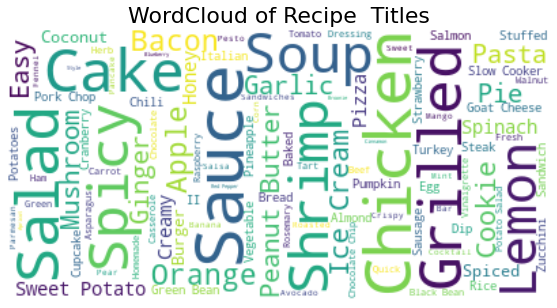

In [8]:
plot_wordcloud(recipes['title'], 'Titles')

Most recipes are about dishes related to Chicken, Orange, Shrimp, Cake.

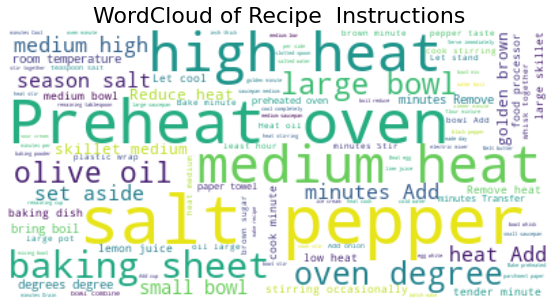

In [9]:
plot_wordcloud(recipes['instructions'], 'Instructions')

Preheat oven is the most appearing instruction.

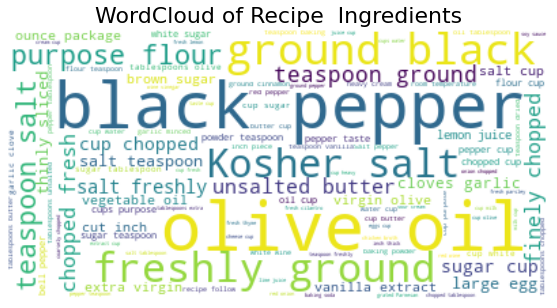

In [10]:
plot_wordcloud(recipes['ingredients'].apply(lambda x: ' '.join(x)), 'Ingredients')

Most preferred ingredient in most of the recipes are seasonings like black pepper, olive oil, and flour

## Preprocessing and Data Preparation

In [11]:
# We will consider following commonly used words as they won't be useful for our analysis
# source: https://en.wikibooks.org/wiki/Cookbook:Units_of_measurement

to_remove = [
    'tablespoon',
    'tablespoons',
    'teaspoon',
    'teaspoons',
    'tsp',
    'tsps',
    'tbsp',
    'tbsps',
    'pound',
    'pounds',
    'grams',
    'mg',
    'mm',
    'm',
    'ounce'
    'ounces',
    'kg',
    'inch',
    'crushed',
    'chopped',
    'finely',
    'softened',
    'cups',
    'cup'
]

# decontract words
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"isn\'t", "is not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# we will also remove any punctuations and digits from our data
translation_table = str.maketrans('', '', string.punctuation + string.digits)

In [12]:
def preprocess(items):
    results = []
    wnl = WordNetLemmatizer()
    nltk.download('wordnet')

    for item in items:
        # a. replace hyphens with space
        item = item.lower().replace('-', ' ') 

        # b. remove newlines, tabs
        item = item.replace('\n', '').replace('\t', '') 

        # c. remove punctuations and digits
        item = item.translate(translation_table) 

        # d. remove html and url tags from text
        item = re.sub(r"http\S+", "", item)
        item = BeautifulSoup(item, 'lxml').get_text()

        # e. decontract words
        item = decontracted(item) 

        # f. remove stop words
        item = remove_stopwords(item) # genism defined
        for stop_word in to_remove: # custom stop words
            item = item.replace(stop_word, '')

        # g. remove words with length lesser than three since most often they're stop words
        # h. and lemmatize
        item = [wnl.lemmatize(word) for word in item.split() if len(word) > 2]
        
        results.append(item)
    
    return results

In [13]:
instructions = recipes.instructions.values.tolist()
ingredients = [', '.join(ingredient) for ingredient in recipes.ingredients.values]

train_data = instructions + ingredients
train_data[:5]

['Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n',
 'In a slow cooker, mix cream of mushroom soup, dry onion soup mix and water. Place pot roast in slow cooker and coat with soup mixture.\nCook on High setting for 3 to 4 hours, or on Low setting for 8 to 9 hours.\n',
 'Preheat oven to 350 degrees F (175 degrees C). Lightly grease a 5x9 inch loaf pan.\nPress the brown sugar in the bottom of the prepared loaf pan and spread the ketchup over the sugar.\nIn a mixing bowl, mix thoroughly all remaining ingredients and shape into a loaf. Place on top of the ketchup.\nBake in preheated oven for 1 hour or until juices are clear.\n',
 'Preheat oven to 350 degrees F (175 degrees C).\nCream together the butter, white sugar, and brown sugar until smooth. Beat in the eggs 

In [14]:
train_data_preprocessed = preprocess(train_data)
train_data_preprocessed[:2]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


[['place',
  'chicken',
  'butter',
  'soup',
  'onion',
  'slow',
  'cooker',
  'water',
  'covercover',
  'cook',
  'hour',
  'high',
  'inutes',
  'serving',
  'place',
  'torn',
  'biscuit',
  'dough',
  'slow',
  'cooker',
  'cook',
  'dough',
  'longer',
  'raw',
  'center'],
 ['slow',
  'cooker',
  'crea',
  'ushroo',
  'soup',
  'dry',
  'onion',
  'soup',
  'water',
  'place',
  'pot',
  'roast',
  'slow',
  'cooker',
  'coat',
  'soup',
  'ixturecook',
  'high',
  'setting',
  'hour',
  'low',
  'setting',
  'hour']]

In [ ]:
# save preprocessed train data
with open('data/train_data.pkl', 'wb') as f:
    pickle.dump(train_data_preprocessed, f)

# save the raw data too
with open('data/train_data_raw.pkl', 'wb') as f:
    pickle.dump(train_data, f)

recipes.to_csv('recipes.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!cp -r data/train_data_raw.pkl /content/gdrive/MyDrive/colab/xlabs/
!cp -r data/train_data.pkl /content/gdrive/MyDrive/colab/xlabs/